# Task 2: Predicting customer buying behaviour
## 6. Modeling and evaluation

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report


import scikitplot as skplt
from yellowbrick.classifier import discrimination_threshold

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

## Load the data

In [2]:
x = pd.read_pickle("x_bal.pickle")
y = pd.read_pickle("y_bal.pickle")

## Modeling

#### Split train and test sets

In [3]:
train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.3)

### Hyperparameter tuning using RandomSearchCV

In [4]:
pipe = Pipeline([('algorithm',RandomForestClassifier())])

grid = [{'algorithm': [LogisticRegression()],
         'algorithm__n_jobs': [-1],
         'algorithm__solver': ['saga'],
         'algorithm__penalty': ['elasticnet', 'l1', 'l2', 'none'],
         'algorithm__C': [0,0.25,0.5,0.75,1]},
        
        {'algorithm': [RandomForestClassifier()],
         'algorithm__n_jobs': [-1],
         'algorithm__max_depth': [5,10,15],
         'algorithm__n_estimators': [50,100,200]},
        
        {'algorithm': [XGBClassifier()],
         'algorithm__n_jobs': [-1],
         'algorithm__verbosity': [0],
         'algorithm__importance_type': ["weight"],
         'algorithm__learning_rate': [0.01,0.025,0.05,0.1],
         'algorithm__max_depth': [5,10,20],
         'algorithm__reg_alpha': [0,0.1,0.5,1],
         'algorithm__reg_lambda': [0.01,0.1,1],
         'algorithm__n_estimators': [100,500,1000]},
         
        
        {'algorithm': [HistGradientBoostingClassifier()],
         'algorithm__learning_rate': [0.01,0.025,0.05,0.1],
         'algorithm__max_iter': [50,100,200],
         'algorithm__max_depth': [5,10,20],
         'algorithm__min_samples_leaf': [500],
         'algorithm__scoring': ['roc_auc'],
         'algorithm__l2_regularization': [0,0.25,0.5,0.75,1]}
       ]

In [5]:
random_search = RandomizedSearchCV(estimator = pipe,
                                   param_distributions = grid, 
                                   n_iter = 5, 
                                   cv = 3, 
                                   scoring = 'roc_auc', 
                                   verbose = 0,
                                   n_jobs = -1)

model = random_search.fit(train_x,train_y)

pd.DataFrame(random_search.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm__verbosity,param_algorithm__reg_lambda,param_algorithm__reg_alpha,param_algorithm__n_jobs,param_algorithm__n_estimators,param_algorithm__max_depth,param_algorithm__learning_rate,param_algorithm__importance_type,param_algorithm,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,2.39,0.02,0.04,0.00,0,0.01,1,-1,100,5,0.10,weight,"XGBClassifier(base_score=None, booster=None, c...","{'algorithm__verbosity': 0, 'algorithm__reg_la...",0.75,0.76,0.77,0.76,0.01,1
3,6.03,0.10,0.08,0.00,0,1,1,-1,100,10,0.03,weight,"XGBClassifier(base_score=None, booster=None, c...","{'algorithm__verbosity': 0, 'algorithm__reg_la...",0.75,0.76,0.76,0.75,0.01,2
0,22.34,0.40,0.24,0.01,0,0.01,0.10,-1,1000,5,0.05,weight,"XGBClassifier(base_score=None, booster=None, c...","{'algorithm__verbosity': 0, 'algorithm__reg_la...",0.74,0.74,0.75,0.75,0.00,3
4,19.65,2.21,0.25,0.06,0,1,0.10,-1,500,10,0.05,weight,"XGBClassifier(base_score=None, booster=None, c...","{'algorithm__verbosity': 0, 'algorithm__reg_la...",0.73,0.74,0.74,0.74,0.00,4
1,25.29,0.20,0.49,0.01,0,0.10,0.10,-1,500,10,0.05,weight,"XGBClassifier(base_score=None, booster=None, c...","{'algorithm__verbosity': 0, 'algorithm__reg_la...",0.73,0.73,0.74,0.73,0.01,5


#### Predict probablities

In [6]:
pred = model.best_estimator_.predict_proba(val_x)[:, 1]

#### Evaluate model

In [7]:
roc_auc_score(val_y, pred)

0.7708705297339773

In [8]:
model.best_estimator_

Pipeline(steps=[('algorithm',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type='weight',
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

The best algorithm after applying a RandomSearchCV hyperparameter optimization with cross validation (3 differents folds) is:

- XGBClassifier:
    -   learning_rate = 0.1
    -   max_depth = 5
    -   n_estimators = 100

#### The feature importances are the following

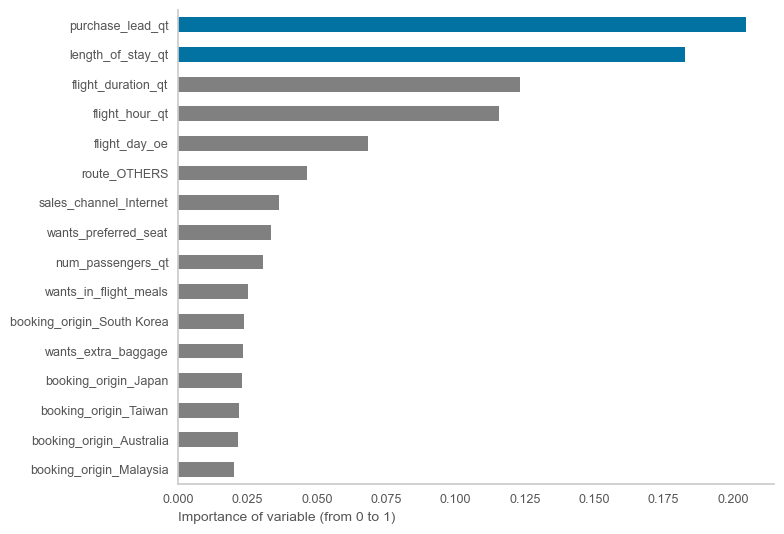

In [35]:
temp = pd.Series(model.best_estimator_[0].feature_importances_, index=train_x.columns).sort_values(ascending=True)[-30:]
colors = ["gray"]*(len(temp) - 2) + ["b"]*2

temp.plot(kind="barh", color=colors)

plt.xticks(size=9, color="#555555")
plt.yticks(size=9, color="#555555")
plt.xticks(rotation=0)
# plt.ylabel("Most important variables", loc="left",size=12, color="#555555")
plt.xlabel("Importance of variable (from 0 to 1)", loc="left",size=10, color="#555555");

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);

plt.grid(False)
plt.tight_layout();


#### The most important features are the purchase lead (the amount of days the trip is booked in advanced) and length of stay in the destination, as well as the flight duration and flight hour. On the other hand, the booking origin is not so important.